# Simulation of a Prescribed Fire policy 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import duckdb
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from prescribed.estimate.simulations import (
    make_model,
    make_predictions,
    simulation_data,
    calculate_benefits,
)
from prescribed.plot import template_plots

# Set the font to be serif, rather than sans
plt.rcParams["font.family"] = "Noto Mono"

# Set the font size to be 12
plt.rcParams["font.size"] = 12

# Path for data
data_path = "/mnt/sherlock/oak/prescribed_data/"

How can we translate the policy in acres to our model parameters? We have to define the size of the treatments and the number of them to know how many 1 sq-km grids we need 

In [3]:
policy_size = 1_000_000
size_rx = 1_000

print(f"Number of policy 1 sq-km pixels: {policy_size / 247.105}")
print(
    f"If all fires are of {size_rx} acres, then the size is: {size_rx / 247.105} sq-km"
)
print(f"Number of fires in the policy area: {policy_size / size_rx}")

Number of policy 1 sq-km pixels: 4046.8626697153036
If all fires are of 1000 acres, then the size is: 4.046862669715304 sq-km
Number of fires in the policy area: 1000.0


To run simulation we need some intermediary obhjects: 
 1. The actual observed severity for the same space. For this we need to make some data wrangling.  
 2.  What is the possible space of the simulation (i.e. conifer forested areas in California)

In [4]:
# Load DNBR data and save to parquet to make it nicer for DuckDB
dnbr = pd.read_feather(
    os.path.join(data_path, "processed/dnbr_gee_inmediate/dnbr_long.feather")
).drop(columns=["spatial_ref"], errors="ignore")

# Load MTBS dataset to add year to the DNBR data
mtbs = (
    gpd.read_file(
        os.path.join(
            data_path, "geoms/mtbs_perims_DD_updated/mtbs_perims_DD.shp"
        )
    )
    .to_crs("EPSG:3310")
    .drop(columns=["spatial_ref"], errors="ignore")
)

# Merge it to get years
mtbs["year"] = mtbs.Ig_Date.dt.year

dnbr = dnbr.merge(
    mtbs[["Event_ID", "year"]],
    right_on="Event_ID",
    left_on="event_id",
    how="left",
)
dnbr.drop(columns=["Event_ID"], inplace=True)

# Subset and save to parquet to make it nicer for DuckDB.
# Here we bottom code dnbr to avoid weird and large negative values
dnbr["dnbr"] = np.where(dnbr.dnbr < 0, 0, dnbr.dnbr)

# Because of some dnbr issues (buffered data), we need to remove some of the data
# by using the templates we have from MTBS (remove grids in the buffer). We could
# normally do this by a spatial join, but we have a lot of data and it's slow.
treatments = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/treatments_mtbs.feather"
).drop(columns=["spatial_ref"], errors="ignore")

treatments_dnbr = treatments.merge(
    dnbr[["year", "dnbr", "lat", "lon", "grid_id"]],
    left_on=["lat", "lon", "year"],
    right_on=["lat", "lon", "year"],
    how="left",
)

# Clean treatments to only be in Event ID in California and have data
treatments_dnbr = treatments_dnbr[
    (treatments_dnbr.Event_ID.str.startswith("CA"))
    & (~treatments_dnbr.dnbr.isna())
]

# Clean repeated observations for the same fire
treatments_dnbr_clean = treatments_dnbr.groupby(
    ["year", "Event_ID", "Incid_Name", "grid_id", "Ig_Date", "Incid_Type"],
    as_index=False,
).dnbr.max()

treatments_dnbr_clean.to_parquet("../data/dnbr.parquet")


<Axes: xlabel='lon', ylabel='lat'>

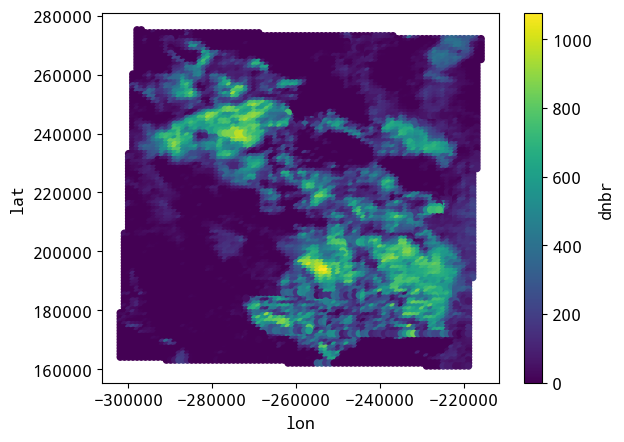

In [5]:
dnbr[dnbr.event_id == "CA3966012280920200817"].plot(
    x="lon", y="lat", kind="scatter", c="dnbr"
)

<Axes: xlabel='lon', ylabel='lat'>

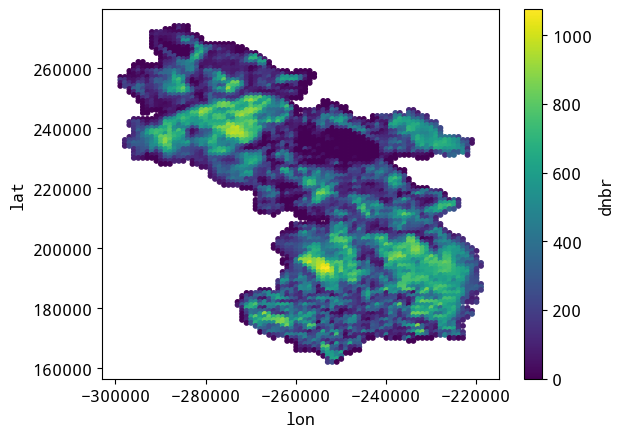

In [6]:
treatments_dnbr[treatments_dnbr.Event_ID == "CA3966012280920200817"].plot(
    x="lon", y="lat", kind="scatter", c="dnbr", s=10
)

In [9]:
# Now create our simulation space :)
sim_data = simulation_data(
    template="/mnt/sherlock/oak/prescribed_data/geoms/templates/template.tif",
    land_type="/mnt/sherlock/oak/prescribed_data/processed/land_type/land_type.feather",
    roads=[
        "/mnt/sherlock/oak/prescribed_data/raw/os_roads_ca/norcal/gis_osm_roads_free_1.shp",
        "/mnt/sherlock/oak/prescribed_data/raw/os_roads_ca/socal/gis_osm_roads_free_1.shp",
    ],
    only_roads=False,
    buf=10_000,
    road_type="secondary",
)

### Plot animation of treatment 

Having created the simulations, we can visualize how the treatments are distributed in space and time. This is a simple implementation of an animation that shows the treatment distribution by `year_treat`. Notice we load only the first simulation (`sim == 1`) for the larger policy area (`4000`)

In [10]:
test_sim = duckdb.query(
    """
select *
from '../data/policy_no_spill_4000/*.parquet'
where sim == 1
"""
).to_df()

In [27]:
test_sim

,lat,lon,year,year_treat,grid_id,land_type,coeff,sim
0,10152.596997,-5913.82085,2011,2010,403408,2.0,-82.305592,1
1,119152.596997,-30913.82085,2011,2010,303539,2.0,-100.048163,1
2,43152.596997,-31913.82085,2011,2010,373154,2.0,-123.781522,1
3,327152.596997,-94913.82085,2011,2010,112947,2.0,-119.401766,1
4,181152.596997,-255913.82085,2011,2010,246522,2.0,-109.480012,1
...,...,...,...,...,...,...,...,...
311995,-207847.403003,-114913.82085,2022,2021,602987,2.0,-59.665377,1
311996,57152.596997,-42913.82085,2022,2021,360319,2.0,-106.005421,1
311997,338152.596997,-63913.82085,2022,2021,102902,2.0,-123.126275,1
311998,361152.596997,-306913.82085,2022,2021,81591,2.0,-56.590612,1


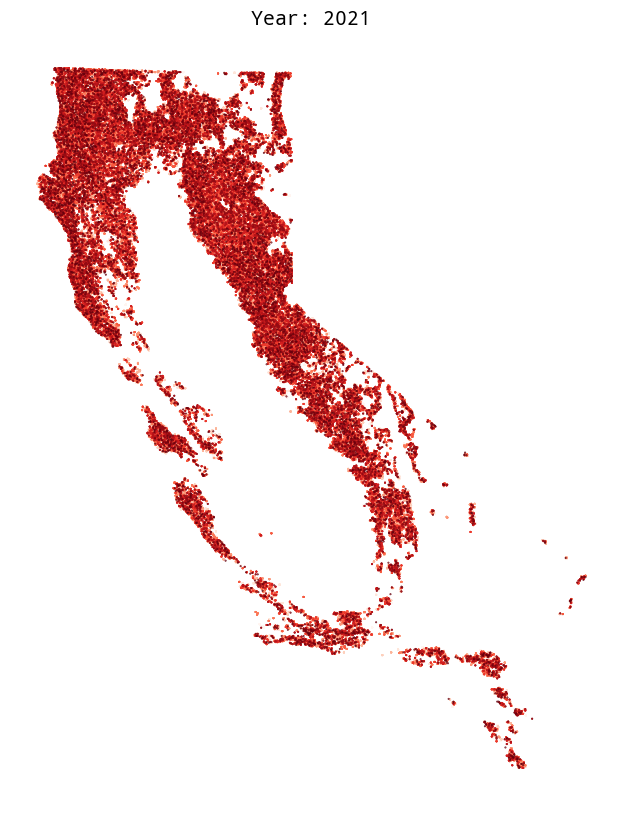

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Transform the DataFrame to a GeoDataFrame
test_sim = gpd.GeoDataFrame(
    test_sim,
    geometry=gpd.points_from_xy(test_sim.lon, test_sim.lat),
    crs="EPSG:3110",
)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 10))

# Set limits of the plot
# ax.set_xlim(-400_000, -300_000)
# ax.set_ylim(200_000, 400_000)

# Remove axis
ax.axis("off")

# Get unique years
years = sorted(test_sim["year_treat"].dropna().unique())


# Define the update function
def update(year):
    ax.clear()
    # ax.set_xlim(-400_000, -300_000)
    # ax.set_ylim(200_000, 400_000)
    ax.axis("off")
    test_sim[test_sim["year_treat"] <= year].plot(
        ax=ax, column="year_treat", legend=False, markersize=0.2, cmap="Reds"
    )
    ax.set_title(f"Year: {year}")


# Create the animation
ani = FuncAnimation(fig, update, frames=years, repeat=False)

# Save the animation as a GIF or MP4
ani.save("animation.gif", writer="imagemagick", fps=1)
# ani.save('animation.mp4', writer='ffmpeg', fps=1)

# Display the animation
plt.show()

### Read simulations and analize benefits

We use `duckdb` to read all the results from all simulation for a specific policy size. Here we create a large `df` data frame which contains each simulation with its corresponding real value from the `dnbr.parquet` we created at the beginning and then we will be doing different aggregations of the data to check for some insights or possible red flags. 

In [39]:
# Read in all the sims to merge with dnbr data
df = duckdb.query("""
with sim as (
SELECT lat, lon, year, year_treat, coeff, sim, land_type, grid_id
FROM '../data/policy_no_spill_4000/*.parquet') 
SELECT d.grid_id,
       d.event_id,
       d.year,
       s.year_treat, 
       s.coeff, 
       s.sim, 
       d.dnbr,
       s.land_type,
       d.dnbr + s.coeff as sim_dnbr,
FROM sim s
right join (SELECT grid_id, year, dnbr, event_id
                  FROM "../data/dnbr.parquet") as d
ON s.grid_id = d.grid_id AND s.year = d.year
""")

# Aggregated data by year and year_treat to plot
df_year_treat = duckdb.query("""
select year, year_treat, mean(coeff) as coeff_mean
from df
where year_treat is not null
group by year, year_treat
""")

# Aggregated data by year and sim to plot
df_year_treat_sim = duckdb.query("""
select year, year_treat, sim, mean(coeff) as coeff_mean
from df
group by year, sim, year_treat
""")


<Axes: xlabel='Year', ylabel='Simulated change in $\\Delta$NBR'>

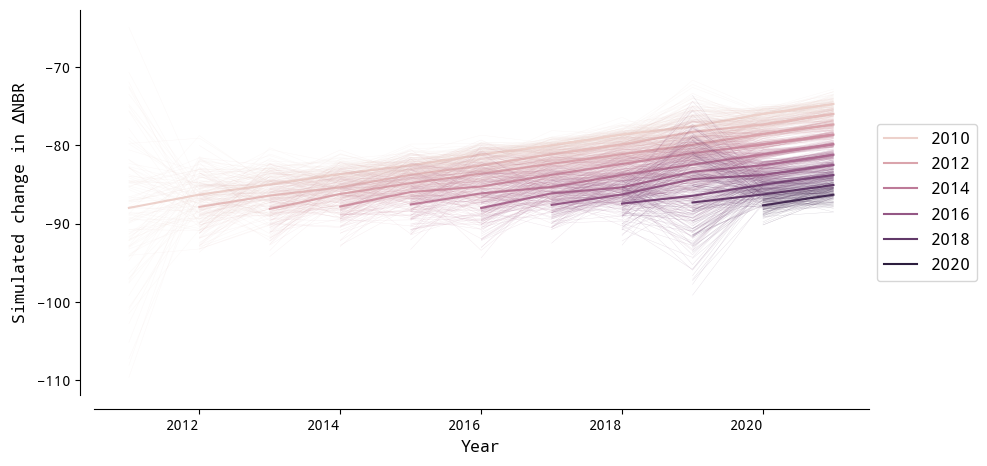

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(
    data=df_year_treat.to_df(),
    x="year",
    y="coeff_mean",
    hue="year_treat",
    ax=ax,
)

sns.lineplot(
    data=df_year_treat_sim.to_df(),
    x="year",
    y="coeff_mean",
    units="sim",
    estimator=None,
    hue="year_treat",
    legend=False,
    linewidth=0.25,
    ax=ax,
    alpha=0.2,
)

# Move legend to the right outside of the plot
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))

# Apply template
template_plots(ax, xlab="Year", ylab=r"Simulated change in $\Delta$NBR")

# Save plot
# plt.savefig("../figs/simulations_coefs.png", bbox_inches="tight")

/home/topcat/miniforge3/envs/prescribed/lib/python3.10/site-packages/joypy/joyplot.py:234: UserWarning: At least a column/group has no numeric values.
  warn("At least a column/group has no numeric values.")


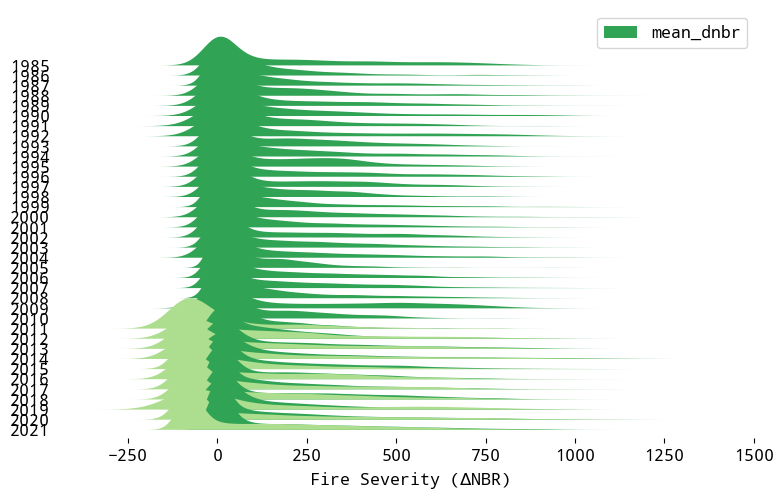

In [ ]:
import joypy

dist_state = duckdb.query("""
select year, grid_id, 
    mean(dnbr) as mean_dnbr, 
    mean(sim_dnbr) as mean_sim_dnbr
from df 
where year is not NULL
group by year, grid_id
""").to_df()

# dist_state = pd.read_csv("../data/joyplot_data.csv")

labels = [str(int(d)) for d in dist_state.year.unique()]
fig, axes = joypy.joyplot(
    dist_state,
    by="year",
    column=["mean_dnbr", "mean_sim_dnbr"],
    legend=True,
    figsize=(8, 5),
    fade=False,
    overlap=1,
    linewidth=0,
    tails=0.1,
    fill=True,
    ylim="max",
    # sublabels = ["$\Delta$NBR", "Simulated $\Delta$NBR"],
    color=["#31a354", "#addd8e"],
)

# Change axis labels
for ax in axes:
    ax.set_xlabel("Fire Severity ($\Delta$NBR)")
# Save plot
# plt.savefig("../figs/dnbr_simulated_joy.png", dpi=300, bbox_inches="tight")

### Check totals across state to calculate benefits

#### Severity 

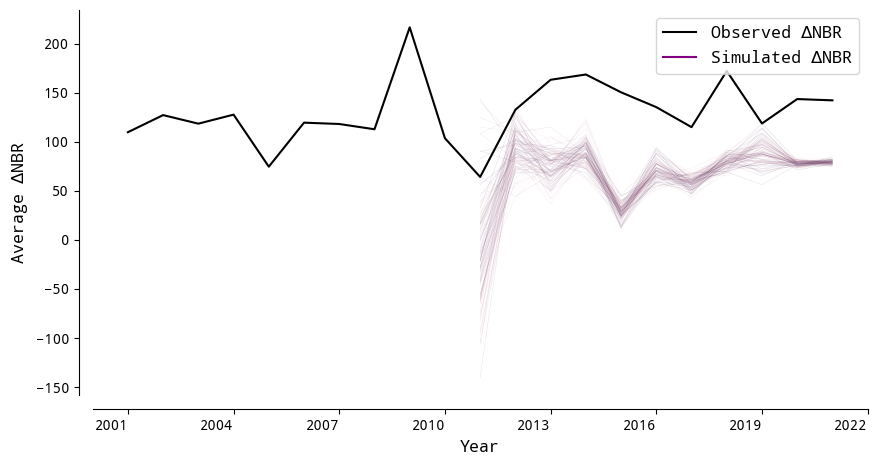

In [7]:
import matplotlib.lines as mlines
import seaborn as sns

severity_raw = duckdb.query("""
select year, 
    sum(dnbr) as sum_dnbr,
    mean(dnbr) as mean_dnbr
from '../data/dnbr.parquet'
where year > 2000
group by year
""").to_df()

severity = duckdb.query("""
with sim as (
SELECT lat, lon, year, year_treat, coeff, sim, land_type, grid_id
FROM '../data/policy_no_spill_4000/*.parquet'),
df as (
SELECT d.grid_id,
       d.year, 
       d.event_id,
       s.year_treat, 
       s.sim, 
       d.dnbr, 
       d.dnbr - abs(s.coeff) as sim_dnbr
FROM sim s
right join (SELECT grid_id, year, dnbr, event_id
            FROM "../data/dnbr.parquet") as d
ON s.grid_id = d.grid_id AND s.year = d.year),
df_sim as (
select year, 
    sim,
    mean(sim_dnbr) as sum_sim_dnbr,
from df
group by sim, year
) 
select *
from df_sim
where year > 2010
""").to_df()

# Use seaborn to plot the time series data and hue by simulation
fig, ax = plt.subplots(1, 1, figsize=(10, 5))


severity_raw.plot.line(
    x="year", y="mean_dnbr", ax=ax, label="Observed $\Delta$NBR", color="black"
)

sns.lineplot(
    data=severity,
    x="year",
    hue="sim",
    y="sum_sim_dnbr",
    linewidth=0.25,
    ax=ax,
    alpha=0.2,
    legend=False,
)

# Apply template
template_plots(ax, xlab="Year", ylab=r"Average $\Delta$NBR")

# Change x-axis labels to be integers
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

# Add only one label for the simulated lines
# Add custom legend entries
observed_line = mlines.Line2D(
    [], [], color="black", label="Observed $\Delta$NBR"
)
simulated_line = mlines.Line2D(
    [], [], color="purple", label="Simulated $\Delta$NBR"
)
ax.legend(handles=[observed_line, simulated_line], loc="upper right")


# Save plot
plt.savefig("../figs/simulated_severity.png", bbox_inches="tight")


#### Emissions

In [12]:
df = duckdb.query("""
WITH cross_product AS (
    SELECT d.*, s.sim
    FROM (
        SELECT * FROM '../data/dnbr.parquet'
        WHERE year >= 2010
    ) AS d
    CROSS JOIN (
        SELECT range AS sim
        FROM range(100)
    ) AS s
),
sim AS (
    SELECT lat, lon, year, year_treat, coeff, sim, land_type, grid_id
    FROM '../data/policy_no_spill_4000/*.parquet'
)
SELECT d.grid_id,
    d.year, 
    d.event_id,
    s.year_treat, 
    s.coeff, 
    d.sim, 
    d.dnbr, 
    s.land_type,
    d.dnbr + coalesce(s.coeff, 0) as sim_dnbr
FROM sim s
RIGHT JOIN cross_product AS d
ON s.grid_id = d.grid_id AND s.year = d.year AND s.sim = d.sim
""")

sim_severity = duckdb.query("""
with year_agg as (
select event_id as event_id,
        year,                            
        sim, 
        sum(dnbr) as sum_dnbr,
        sum(sim_dnbr) as sum_sim_dnbr,
from df
group by sim, event_id, year
)
select * from year_agg
""").to_df()

sim_severity


,event_id,year,sim,sum_dnbr,sum_sim_dnbr
0,CA4022812303620170913,2017,11,14239.086247,12361.840923
1,CA3838712252020171009,2017,11,61868.107967,59826.169508
2,CA3502012029920170706,2017,11,38974.863060,38181.169236
3,CA4198012316420170811,2017,11,34582.517383,31391.717734
4,CA4011512332020170808,2017,11,3581.964516,3193.565979
...,...,...,...,...,...
52195,CA4003112117620100731,2010,56,NaN,NaN
52196,CA4094712034320100726,2010,72,NaN,NaN
52197,CA4114311975020120805,2012,49,NaN,NaN
52198,CA4114311975020120805,2012,84,NaN,NaN


In [59]:
smoke_linked_raw = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked.feather"
)

# Select threshold
smoke_linked = smoke_linked_raw[smoke_linked_raw.coverage_threshold == 0.1]

# Remove outliers from smoke linked data
smoke_linked = smoke_linked[
    (smoke_linked.sum_severity <= smoke_linked.sum_severity.quantile(0.975))
    & (smoke_linked.sum_severity >= smoke_linked.sum_severity.quantile(0.025))
]

coefs = make_model(
    smoke_linked,
    formula="sum_contrib ~ sum_severity + I(sum_severity ** 2) + total_days + total_pixels",
    fe=False,
)

# Merge liked data and only estimate over the same fires we matched
sim_severity_merge = sim_severity.merge(
    smoke_linked,
    on=["event_id", "year"],
)

In [60]:
coefs

{'ols':                               coef           se
 Intercept            -40967.375677  4261.681871
 sum_severity             -0.057153     0.300497
 I(sum_severity ** 2)      0.000008     0.000001
 total_days             6372.569624   340.848358
 total_pixels             29.348749    50.299865}

In [45]:
# Estimate boostrap confidence intervals

# Range of severities
range_severity = np.arange(
    smoke_linked["sum_severity"].min(),
    smoke_linked["sum_severity"].max(),
    100,
)

boot_samples = []
for _ in tqdm.tqdm(range(100), desc="Bootstrappin'"):
    # Sample with replacement
    sample = smoke_linked.sample(frac=1, replace=True)

    # Estimate the model
    try:
        model = make_model(
            sample,
            formula="sum_contrib ~ sum_severity + I(sum_severity ** 2) + total_days + total_pixels",
            fe=True,
        )

        # Select only the coefficients of interest
        coefs_ = model["fe"]
        coefs_ = coefs_[coefs_.index.str.contains("sum_severity")].values[:, 0]

        # Calculate the marginal effect
        marginal = (2 * coefs_[1]) * range_severity + coefs_[0]

        boot_samples.append(marginal)
    except Exception as e:
        print(e)
        pass

boots = np.vstack(boot_samples)
bounds = np.percentile(boots, [2.5, 97.5], axis=0)

Bootstrappin': 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


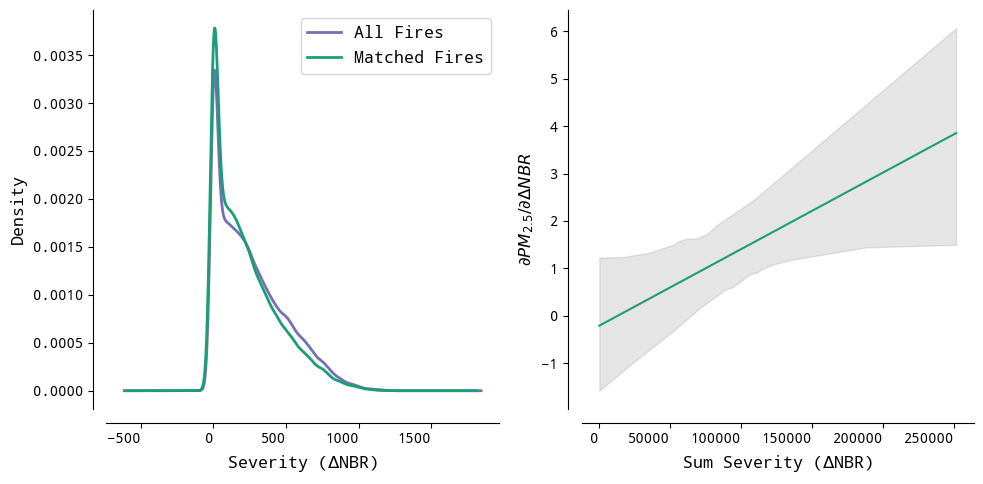

In [50]:
# Plot the predictions
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
treatments_dnbr[treatments_dnbr.year > 2006].dnbr.plot.density(
    ax=ax[0], color="#7570b3", linewidth=2
)
treatments_dnbr[
    (treatments_dnbr.year > 2006)
    & (treatments_dnbr.event_id.isin(smoke_linked.event_id.tolist()))
].dnbr.plot.density(ax=ax[0], color="#1b9e77", linewidth=2)

# Apply template
template_plots(ax[0], xlab="Severity ($\Delta$NBR)", ylab="Density")

# Add a legend for the two density lines
ax[0].legend(["All Fires", "Matched Fires"], loc="upper right")

# Plot marginal effect of severity on emissions
ax[1].fill_between(
    range_severity,
    bounds[0],
    bounds[1],
    alpha=0.2,
    color="gray",
)

# Plot median prediction as a line
ax[1].plot(
    range_severity,
    np.mean(boots, axis=0),
    color="#1b9e77",
)

# Apply template
template_plots(
    ax[1],
    xlab="Sum Severity ($\Delta$NBR)",
    ylab="$\partial PM_{2.5} / \partial \Delta NBR$",
)


plt.tight_layout()

# Save plot as a vector graphic
plt.savefig("../figs/severity_emissions_link.png", bbox_inches="tight")

<Axes: xlabel='lon', ylabel='lat'>

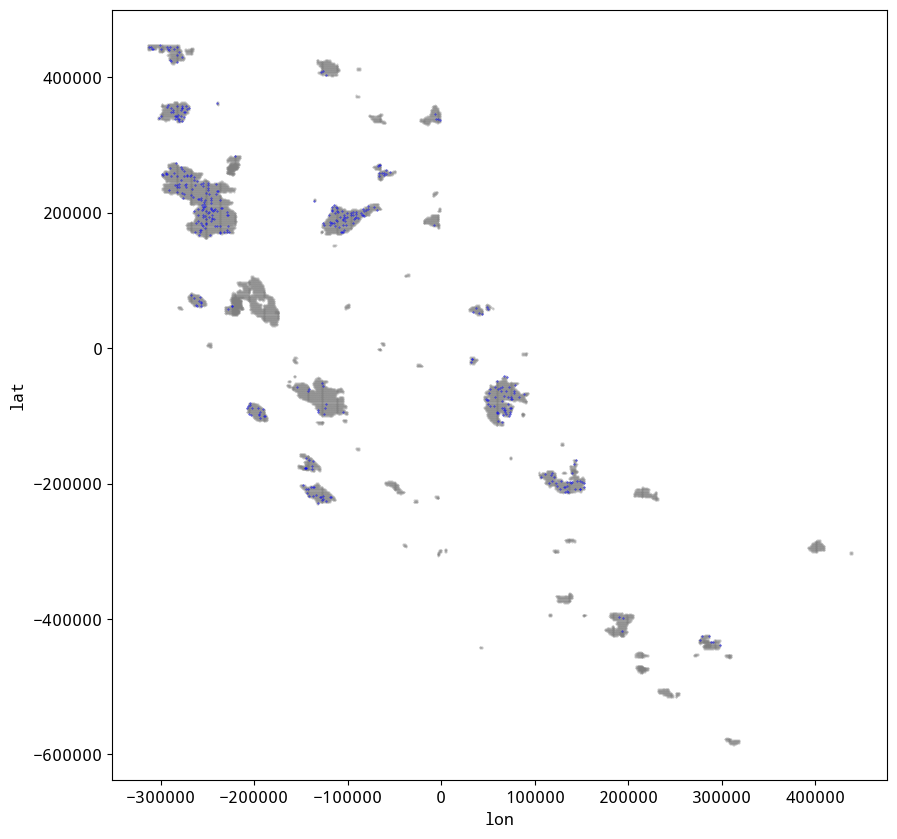

In [180]:
test_sim = duckdb.query("""
with test_sim as (
select *, 1 as rx,
from '../data/policy_no_spill_4000/sim_1_10.parquet'
where sim == 1 and year_treat == 2010
),
dnbr as (
select * from '../data/dnbr.parquet'
where year = 2020
), merge as (
select d.grid_id, 
       d.year, 
       d.event_id,
       d.lat, 
       d.lon, 
       coalesce(s.rx, 0) as rx, 
       coalesce(s.year_treat, 0) as year_treat,
       coalesce(d.dnbr, 0) as dnbr,
       coalesce(s.coeff, 0) as coeff,
       coalesce(d.dnbr + coalesce(s.coeff, 0), 0) as sim_dnbr
FROM dnbr d
LEFT JOIN test_sim s
ON s.grid_id = d.grid_id and s.year = d.year
) 
select * from merge
""").to_df()


# Plot the points and color the ones that are treated
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the points
test_sim.plot.scatter(x="lon", y="lat", ax=ax, color="gray", alpha=0.5, s=0.1)

# Plot the rx points
test_sim[test_sim.rx == 1].plot.scatter(
    x="lon", y="lat", ax=ax, color="blue", s=0.1
)


In [225]:
dnbr_data = duckdb.query("""
with dnbr_data as (
select 
        grid_id, 
        year, 
        Event_ID as event_id, 
        Incid_Name as event_name, 
        dnbr 
from '../data/dnbr.parquet' 
where year > 2010
)
select event_id, 
       event_name,      
       year,
       sum(dnbr) as sum_dnbr
from dnbr_data
group by event_id, event_name, year
""").to_df()

df = duckdb.query("""
WITH simulation_data AS (
    SELECT *
    FROM '../data/policy_no_spill_1000/*.parquet'
    where sim is not null
), 
dnbr_data AS (
select 
        grid_id, 
        year, 
        Event_ID as event_id, 
        Incid_Name as event_name, 
        dnbr 
from '../data/dnbr.parquet' 
where year > 2010
), 
dnbr_event_agg as (
select event_id, 
       event_name,      
       year,
       sum(dnbr) as sum_dnbr
from dnbr_data
group by event_id, event_name, year
), 
benefits_grid_simulation as (
SELECT  s.grid_id, 
        s.year_treat, 
        s.year, 
        d.event_id, 
        d.event_name, 
        s.sim,
        s.coeff, 
        d.dnbr,
        case when (d.dnbr + s.coeff) < 0 
                  then 0 
                  else d.dnbr + s.coeff 
        end as sim_benefit
from simulation_data s 
inner join dnbr_data d
on s.grid_id = d.grid_id 
    and s.year = d.year
), 
benefits_event_agg as (
select event_id,
       year,
       year_treat, 
       event_name,
       sim,
       sum(sim_benefit) as sum_benefit_event
from benefits_grid_simulation
group by event_id, year, event_name, year_treat, sim
),
total_event_benefits as (
select d.event_id,
       d.event_name,
       d.year,
       d.sum_dnbr,
       coalesce(b.year_treat, 0) as year_treat,
       coalesce(b.sim, 0) as sim,
       coalesce(b.sum_benefit_event, 0) as sum_benefit_event,
       coalesce(d.sum_dnbr - b.sum_benefit_event, d.sum_dnbr) as simulated_sum_dnbr
from benefits_event_agg b
INNER JOIN dnbr_event_agg d
on b.event_id = d.event_id and b.year = d.year)
select * from total_event_benefits
""").to_df()

In [234]:
df_sims = (
    df[["year_treat", "sim"]]
    .drop_duplicates()
    .sort_values(by=["year_treat", "sim"])
    .reset_index(drop=True)
)

dnbr_data_cross = dnbr_data.merge(df_sims, how="cross")

# Clean treatments
dnbr_data_cross = dnbr_data_cross[
    dnbr_data_cross.year > dnbr_data_cross.year_treat
]

In [235]:
simulation_data = dnbr_data_cross.merge(
    df[
        [
            "event_id",
            "year",
            "year_treat",
            "sim",
            "simulated_sum_dnbr",
            "sum_benefit_event",
        ]
    ],
    on=["event_id", "year", "year_treat", "sim"],
    how="left",
)

# Fill nans with 0
simulation_data = simulation_data.assign(
    simulated_sum_dnbr=lambda x: x.simulated_sum_dnbr.fillna(
        simulation_data.sum_dnbr
    ),
    sum_benefit_event=lambda x: x.sum_benefit_event.fillna(0),
)

simulation_data

,event_id,event_name,year,sum_dnbr,year_treat,sim,simulated_sum_dnbr,sum_benefit_event
0,CA3327711653720110721,EAGLE,2011,12450.776077,2010,1,12450.776077,0.0
1,CA3327711653720110721,EAGLE,2011,12450.776077,2010,2,12450.776077,0.0
2,CA3327711653720110721,EAGLE,2011,12450.776077,2010,3,12450.776077,0.0
3,CA3327711653720110721,EAGLE,2011,12450.776077,2010,4,12450.776077,0.0
4,CA3327711653720110721,EAGLE,2011,12450.776077,2010,5,12450.776077,0.0
...,...,...,...,...,...,...,...,...
322735,CA4086312235520210630,SALT,2021,18747.071854,2020,95,18747.071854,0.0
322736,CA4086312235520210630,SALT,2021,18747.071854,2020,96,18747.071854,0.0
322737,CA4086312235520210630,SALT,2021,18747.071854,2020,97,18747.071854,0.0
322738,CA4086312235520210630,SALT,2021,18747.071854,2020,98,18747.071854,0.0


In [236]:
smoke_linked_raw = pd.read_feather(
    "/mnt/sherlock/oak/prescribed_data/processed/smoke_linking/severity_emissions_linked.feather"
)

# Select threshold
smoke_linked = smoke_linked_raw[smoke_linked_raw.coverage_threshold == 0.1]

# # Remove outliers from smoke linked data
# smoke_linked = smoke_linked[
#     (smoke_linked.sum_severity <= smoke_linked.sum_severity.quantile(0.975))
#     & (smoke_linked.sum_severity >= smoke_linked.sum_severity.quantile(0.025))
# ]

coefs = make_model(
    smoke_linked,
    formula="sum_contrib ~ sum_severity + total_days + total_pixels",
    fe=True,
)

In [229]:
coefs["fe"]

,coef,se
Coefficient,,
sum_severity,1.550970,0.497339
total_days,4997.002441,1251.495427
total_pixels,110.167287,101.585573


In [237]:
simulation_data = simulation_data.assign(
    preds_sim_pm=make_predictions(
        simulation_data["simulated_sum_dnbr"].values,
        coefs,
        uncertainty=False,
        degree=1,
    ),
    preds_pm=make_predictions(
        simulation_data["sum_dnbr"].values, coefs, uncertainty=False, degree=1
    ),
)

In [238]:
simulation_data

,event_id,event_name,year,sum_dnbr,year_treat,sim,simulated_sum_dnbr,sum_benefit_event,preds_sim_pm,preds_pm
0,CA3327711653720110721,EAGLE,2011,12450.776077,2010,1,12450.776077,0.0,19310.774861,19310.774861
1,CA3327711653720110721,EAGLE,2011,12450.776077,2010,2,12450.776077,0.0,19310.774861,19310.774861
2,CA3327711653720110721,EAGLE,2011,12450.776077,2010,3,12450.776077,0.0,19310.774861,19310.774861
3,CA3327711653720110721,EAGLE,2011,12450.776077,2010,4,12450.776077,0.0,19310.774861,19310.774861
4,CA3327711653720110721,EAGLE,2011,12450.776077,2010,5,12450.776077,0.0,19310.774861,19310.774861
...,...,...,...,...,...,...,...,...,...,...
322735,CA4086312235520210630,SALT,2021,18747.071854,2020,95,18747.071854,0.0,29076.138038,29076.138038
322736,CA4086312235520210630,SALT,2021,18747.071854,2020,96,18747.071854,0.0,29076.138038,29076.138038
322737,CA4086312235520210630,SALT,2021,18747.071854,2020,97,18747.071854,0.0,29076.138038,29076.138038
322738,CA4086312235520210630,SALT,2021,18747.071854,2020,98,18747.071854,0.0,29076.138038,29076.138038


In [239]:
# Remove bad predictions than don't make sense in theory
simulation_data = simulation_data[
    simulation_data.preds_sim_pm <= simulation_data.preds_pm
]

# Calculate benefits for each simulation
simulation_data["benefit"] = (
    simulation_data["preds_pm"] - simulation_data["preds_sim_pm"]
)

In [240]:
simulation_data

,event_id,event_name,year,sum_dnbr,year_treat,sim,simulated_sum_dnbr,sum_benefit_event,preds_sim_pm,preds_pm,benefit
0,CA3327711653720110721,EAGLE,2011,12450.776077,2010,1,12450.776077,0.0,19310.774861,19310.774861,0.0
1,CA3327711653720110721,EAGLE,2011,12450.776077,2010,2,12450.776077,0.0,19310.774861,19310.774861,0.0
2,CA3327711653720110721,EAGLE,2011,12450.776077,2010,3,12450.776077,0.0,19310.774861,19310.774861,0.0
3,CA3327711653720110721,EAGLE,2011,12450.776077,2010,4,12450.776077,0.0,19310.774861,19310.774861,0.0
4,CA3327711653720110721,EAGLE,2011,12450.776077,2010,5,12450.776077,0.0,19310.774861,19310.774861,0.0
...,...,...,...,...,...,...,...,...,...,...,...
322735,CA4086312235520210630,SALT,2021,18747.071854,2020,95,18747.071854,0.0,29076.138038,29076.138038,0.0
322736,CA4086312235520210630,SALT,2021,18747.071854,2020,96,18747.071854,0.0,29076.138038,29076.138038,0.0
322737,CA4086312235520210630,SALT,2021,18747.071854,2020,97,18747.071854,0.0,29076.138038,29076.138038,0.0
322738,CA4086312235520210630,SALT,2021,18747.071854,2020,98,18747.071854,0.0,29076.138038,29076.138038,0.0


In [244]:
discount_rates = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1]

# Now calculate the costs of policy emissions! These are the same across all
# years and simulations.
policy_cost = make_predictions(
    severity=np.array(np.array([60] * 1000).sum()).reshape(
        1,
    ),
    coefs=coefs,
    degree=1,
    uncertainty=False,
)

# Aggregate to state level
benefits = simulation_data.groupby(
    ["year", "year_treat", "sim"], as_index=False
)["benefit"].sum()


pv_list = []
for discount_rate in discount_rates:
    for idx, df_year in benefits.groupby(["year_treat", "sim"]):
        year, sim = idx

        # Create discount stream for the range of years in the data
        years_policy = df_year.year.unique().shape[0]
        discount_stream = 1 / (1 + discount_rate) ** np.arange(
            1, years_policy + 1
        )

        # Calculate the PV benefits
        pv = np.sum(df_year.benefit.values @ discount_stream)
        ratio = pv / policy_cost.values[0]

        pv_list.append(
            pd.DataFrame(
                {
                    "year_treat": [year],
                    "sim": [sim],
                    "pv": [pv],
                    "ratio": [ratio],
                    "discount_rate": [discount_rate],
                }
            )
        )


In [245]:
pv = pd.concat(pv_list)
pv = pv[pv.year_treat < 2020]
pv["lag"] = np.abs(pv.year_treat - 2020)
pv

,year_treat,sim,pv,ratio,discount_rate,lag
0,2010,1,111275.094113,1.195758,0.01,10
0,2010,2,106974.099441,1.149540,0.01,10
0,2010,3,113883.287357,1.223786,0.01,10
0,2010,4,105174.832262,1.130205,0.01,10
0,2010,5,101549.790142,1.091251,0.01,10
...,...,...,...,...,...,...
0,2019,95,64882.006447,0.697220,0.10,1
0,2019,96,74097.822490,0.796253,0.10,1
0,2019,97,54333.514082,0.583866,0.10,1
0,2019,98,63952.052308,0.687227,0.10,1


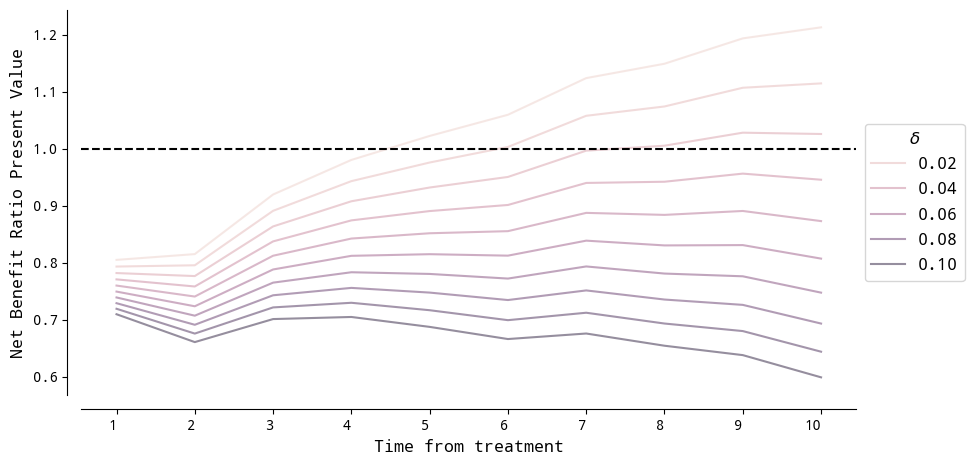

In [246]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(
    data=pv.groupby(["year_treat", "discount_rate"]).mean().reset_index(),
    x="lag",
    y="ratio",
    hue="discount_rate",
    alpha=0.5,
    ax=ax,
)

# Add all numbers in the x-axis
ax.set_xticks(pv.lag.unique())

template_plots(
    ax, xlab="Time from treatment", ylab="Net Benefit Ratio Present Value"
)

# Add a horizontal line at 1
ax.axhline(1, color="black", linestyle="--")

# Move the legend outside the plot and change the title
plt.legend(title=r"$\delta$", loc="center left", bbox_to_anchor=(1, 0.5))

# Save plot
plt.savefig("../figs/pv_benefits.png", bbox_inches="tight")

<Axes: xlabel='year', ylabel='coeff_min'>

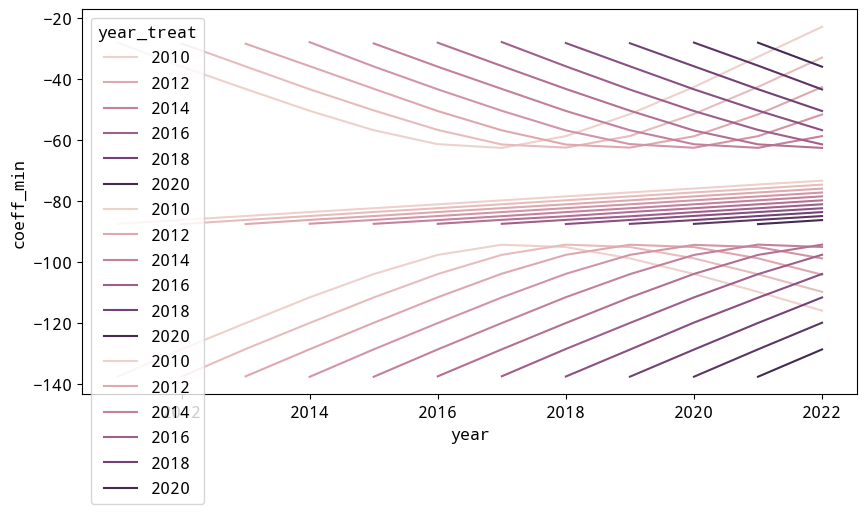

In [108]:
plot_data = duckdb.query("""
select year_treat, year ,quantile(coeff, 0.99) as coeff_max, quantile(coeff, 0.025) as coeff_min, mean(coeff) as coeff_mean
from '../data/policy_no_spill_4000/*.parquet'
group by year_treat, year
""").to_df()

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(data=plot_data, x="year", y="coeff_min", hue="year_treat", ax=ax)

sns.lineplot(data=plot_data, x="year", y="coeff_mean", hue="year_treat", ax=ax)

sns.lineplot(data=plot_data, x="year", y="coeff_max", hue="year_treat", ax=ax)

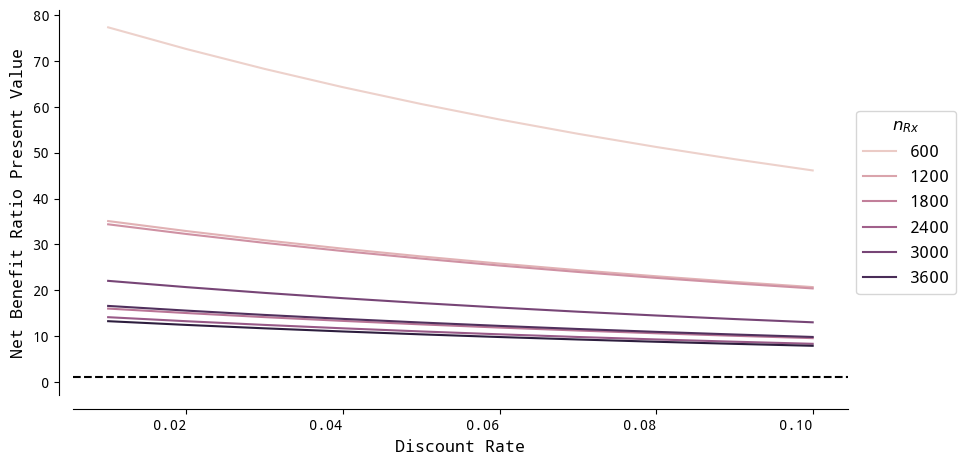

In [217]:
total_npv.sort_values("discount_rate")

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

sns.lineplot(
    data=total_npv,
    x="discount_rate",
    y="npv_mean",
    hue="n_treats",
)

# # Plot marginal effect of severity on emissions
# ax.fill_between(
#     total_npv[total_npv.n_treats.isin([4000])].discount_rate,
#     total_npv[total_npv.n_treats.isin([4000])].npv_q25,
#     total_npv[total_npv.n_treats.isin([4000])].npv_q75,
#     alpha=0.2,
#     color="gray",
# )

template_plots(ax, xlab="Discount Rate", ylab="Net Benefit Ratio Present Value")

# Add a horizontal line at 1
ax.axhline(1, color="black", linestyle="--")

# Move the legend outside the plot and change the title
plt.legend(title=r"$n_{Rx}$", loc="center left", bbox_to_anchor=(1, 0.5))

# Save plot
plt.savefig("../figs/npv.png", bbox_inches="tight")

In [218]:
total_benefits

,year,mean_pred,lower,upper,n_treats
0,2011,4.615548,0.320659,17.973381,500
1,2012,7.992023,1.470126,28.788104,500
2,2013,4.655033,0.414781,21.998098,500
3,2014,5.311687,0.585890,24.266498,500
4,2015,6.799733,1.132149,22.440539,500
...,...,...,...,...,...
6,2017,2.132935,0.668924,6.025220,4000
7,2018,1.355754,0.242434,4.095571,4000
8,2019,0.991917,0.198536,4.320541,4000
9,2020,2.254892,0.653877,6.837843,4000


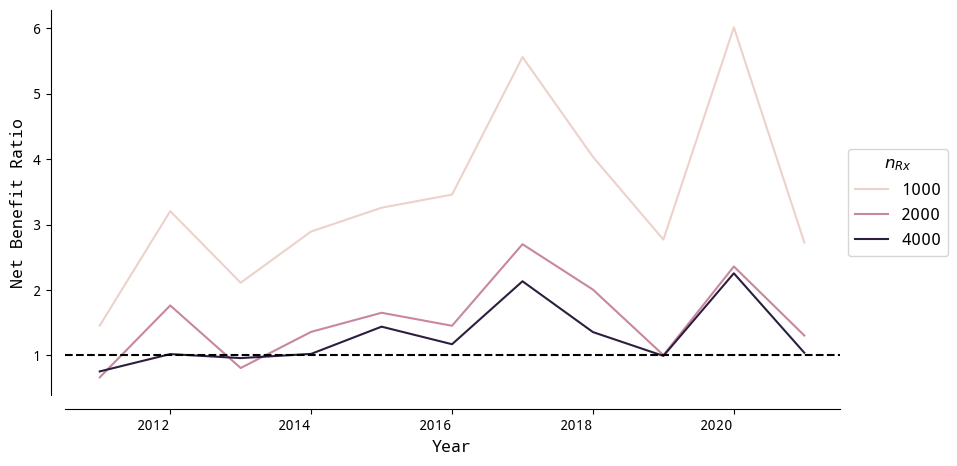

In [219]:
total_benefits

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.lineplot(
    x="year",
    y="mean_pred",
    ax=ax,
    # data=total_benefits[total_benefits.n_treats == 500],
    data=total_benefits[total_benefits.n_treats.isin([1000, 2000, 4000])],
    hue="n_treats",
)

template_plots(ax, xlab="Year", ylab="Net Benefit Ratio")

# Add a horizontal line at 0
ax.axhline(1, color="black", linestyle="--")

# Move the legend outside the plot and change the title
plt.legend(title=r"$n_{Rx}$", loc="center left", bbox_to_anchor=(1, 0.5))

# Save plot
plt.savefig("../figs/benefit.png", bbox_inches="tight")

In [151]:
mtbs_ca = mtbs[mtbs.Event_ID.str.startswith("CA")]
rx = mtbs_ca[mtbs_ca.Incid_Type == "Prescribed Fire"]

dnbr_rx = dnbr[dnbr.event_id.isin(rx.Event_ID.unique())]

In [152]:
dnbr_rx.dnbr.mean()

64.99039

In [153]:
dnbr_rx.merge(land_type[["grid_id", "land_type"]], on="grid_id").groupby(
    "land_type"
).dnbr.describe()

,count,mean,std,min,25%,50%,75%,max
land_type,,,,,,,,
1.0,125.0,-18.280682,169.268433,-525.520996,-77.696571,-27.656284,26.714607,719.607117
2.0,664.0,44.914364,116.065758,-195.060898,-21.241541,20.728214,90.118944,893.658142
3.0,286.0,54.749153,133.070053,-288.274170,-25.410745,34.597330,129.072039,645.773499
4.0,41.0,36.937359,96.155655,-236.524948,-9.253198,11.041381,61.498524,345.623474
5.0,383.0,95.608986,172.773849,-359.005524,-15.823377,39.089489,212.686829,562.061401
7.0,61.0,152.446609,195.035248,-138.112320,-9.656353,65.528442,361.083618,500.401123
8.0,74.0,91.280190,149.570877,-156.526428,-11.446738,65.247818,139.880257,575.173157
10.0,102.0,37.302197,218.067413,-514.768860,-47.543728,-4.578282,115.757357,554.569641
11.0,1.0,-59.975475,NaN,-59.975475,-59.975475,-59.975475,-59.975475,-59.975475
